In [1]:
import open3d as o3d
import pyrealsense2 as rs
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import itertools

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [230]:
# Camera 1
pipeline = rs.pipeline()
config = rs.config()
config.enable_device('233722072412')
config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)

# Camera 2
pipeline_2 = rs.pipeline()
config_2 = rs.config()
config_2.enable_device('032622070359')
config_2.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
config_2.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)


In [235]:
align = rs.align(rs.stream.depth)
cfg = pipeline.start(config)
profile = cfg.get_stream(rs.stream.depth)
intr = profile.as_video_stream_profile().get_intrinsics()



cfg_2 = pipeline_2.start(config_2)
profile_2 = cfg_2.get_stream(rs.stream.depth)
intr_2 = profile_2.as_video_stream_profile().get_intrinsics()

prova_left = []
prova_right = []
cnt = 0
while cnt<60:
    frames = pipeline.wait_for_frames()
    frames_2= pipeline_2.wait_for_frames()
    frames = align.process(frames)
    frames_2 = align.process(frames_2)

    depth_frame = frames.get_depth_frame()
    depth_image = np.asarray(depth_frame.get_data())
    prova_left.append(depth_image)
    depth_frame_2 =frames_2.get_depth_frame()
    depth_image_2 = np.asarray(depth_frame_2.get_data())
    prova_right.append(depth_image_2)

    color_frame = frames.get_color_frame()
    color_image = np.asarray(color_frame.get_data())
    color_frame_2 = frames_2.get_color_frame()
    color_image_2 = np.asarray(color_frame_2.get_data())

    cnt += 1
pipeline.stop()
pipeline_2.stop()

In [229]:
print(intr_2)

[ 1280x720  p[637.742 352.65]  f[630.168 630.168]  Brown Conrady [0 0 0 0 0] ]


In [88]:
pipeline.stop()
pipeline_2.stop()

In [ ]:
#Da implementare

mean_left = np.mean(np.asarray(prova_left), 0)
mean_right = np.mean(np.asarray(prova_right), 0)

In [236]:
cv2.imwrite("leftDepth.png", depth_image)
cv2.imwrite("leftColor.jpg", color_image)
cv2.imwrite("rightDepth.png", depth_image_2)
cv2.imwrite("rightColor.jpg", color_image_2)

True

In [212]:
depth_raw_left = o3d.io.read_image("leftDepth.png")
color_raw_left = o3d.io.read_image("leftColor.jpg")
depth_raw_right = o3d.io.read_image("rightDepth.png")
color_raw_right = o3d.io.read_image("rightColor.jpg")
rgbd_image_left = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_left, depth_raw_left)
rgbd_image_right = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_right, depth_raw_right)

#print(rgbd_image)

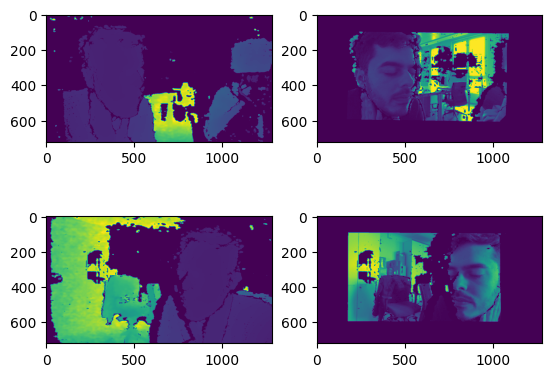

In [213]:
plt.subplot(2,2,1)
plt.imshow(rgbd_image_left.depth)
plt.subplot(2,2,2)
plt.imshow(rgbd_image_left.color)
plt.subplot(2,2,3)
plt.imshow(rgbd_image_right.depth)
plt.subplot(2,2,4)
plt.imshow(rgbd_image_right.color)

In [215]:
camera_intrinsic_left = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr.width, intr.height, intr.fx, intr.fy, intr.ppx, intr.ppy
))
camera_intrinsic_right = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr_2.width, intr_2.height, intr_2.fx, intr_2.fy, intr_2.ppx, intr_2.ppy
))
pcd_left = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_left, camera_intrinsic_left)
pcd_right = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_right, camera_intrinsic_right)

bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0.1, 1]]  # set the bounds
bounding_box_points = list(itertools.product(*bounds))  # create limit points
bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object

# Crop the point cloud using the bounding box:
pcd_left = pcd_left.crop(bounding_box)
pcd_right = pcd_right.crop(bounding_box)

#pcd_left = pcd_left.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
#pcd_right = pcd_right.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

print(np.asarray(pcd_left.points))
o3d.visualization.draw_geometries([pcd_left])
o3d.visualization.draw_geometries([pcd_right])

[[-0.14757095 -0.14381531  0.31      ]
 [-0.14708835 -0.14381531  0.31      ]
 [-0.14660575 -0.14381531  0.31      ]
 ...
 [-0.02159448  0.30654054  0.53799999]
 [ 0.4448648   0.35611123  0.625     ]
 [ 0.44512445  0.35554146  0.62400001]]


In [216]:
import copy

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    #target_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[1.0, 0.0, 0.0],
                                      lookat=[1, 0, 0],
                                      up=[-0., 1, -0.0])

In [221]:
angolo = np.pi/2
source = pcd_left
target = pcd_right
threshold = 2
trans_init = np.asarray([[np.cos(angolo), 0.0, np.sin(angolo), -0.34],
                         [0.0, 1.0, 0.0, 0.0],
                         [-np.sin(angolo), 0.0, np.cos(angolo), 0.0],
                         [0.0, 0.0, 0.0, 1.0]])
draw_registration_result(source, target, trans_init)

IndentationError: unexpected indent (4051417825.py, line 10)

In [224]:
angolo = -np.pi/3
trans_init = np.asarray([[np.cos(angolo), 0.0, np.sin(angolo), -0.34],
                         [0.0, 1.0, 0.0, 0.0],
                         [-np.sin(angolo), 0.0, np.cos(angolo), 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

trans_init

array([[ 0.5      ,  0.       , -0.8660254, -0.34     ],
       [ 0.       ,  1.       ,  0.       ,  0.       ],
       [ 0.8660254,  0.       ,  0.5      ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  1.       ]])

In [145]:
print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(
    source, target, threshold, trans_init)
print(evaluation)

Initial alignment
RegistrationResult with fitness=1.000000e+00, inlier_rmse=3.193374e-02, and correspondence_set size of 174969
Access transformation to get result.


In [146]:
print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(source, target, reg_p2p.transformation)


Apply point-to-point ICP
RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.508279e-02, and correspondence_set size of 174969
Access transformation to get result.
Transformation is:
[[ 0.99637882  0.05011629  0.06868479 -0.32463379]
 [-0.04612867  0.99722327 -0.05846279  0.03033699]
 [-0.07142401  0.05508275  0.99592394  0.00123394]
 [ 0.          0.          0.          1.        ]]


In [69]:
reg_p2p.transformation

array([[ 0.99229137, -0.12280845, -0.01661092,  0.03391924],
       [ 0.12261057,  0.99237675, -0.01245153,  0.00581249],
       [ 0.01801345,  0.01031887,  0.9997845 ,  0.00758199],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [15]:
test = pcd_left.transform(reg_p2p.transformation)
p1_load = np.asarray(test.points)
p1_color = np.asarray(test.colors)
p2_load = np.asarray(pcd_right.points)
p2_color = np.asarray(pcd_right.colors)

p3_load = np.concatenate((p1_load, p2_load), axis=0)
p3_color = np.concatenate((p1_color, p2_color), axis=0)

new_pcd = o3d.geometry.PointCloud()
new_pcd.points = o3d.utility.Vector3dVector(p3_load)
new_pcd.colors = o3d.utility.Vector3dVector(p3_color)

In [16]:
o3d.visualization.draw_geometries([new_pcd])